Image Classification Using CNN with the CIFAR-10 Dataset
using **advanced Hyperparameter Tunning**

In [1]:
pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


In [2]:
# Step 1: Importing necessary libraries

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras_tuner.tuners import RandomSearch
import matplotlib.pyplot as plt

In [3]:
# Step 2: Loading and preprocessing the CIFAR-10 dataset

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [4]:
# Step 3: Defining the class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
# Step 4: Define a function to build the model

def build_model(hp):
    model = models.Sequential()

    # Tune the number of Convolutional Layers (1, 2 or 3)
    for i in range(hp.Int('conv_layers', 1, 3)):
      if i == 0:
        model.add(layers.Conv2D(
            filters = hp.Int('filters_' + str(i), min_value=32, max_value=128, step=16),
            kernel_size = (3, 3),
            activation = 'relu',
            input_shape = (32, 32, 3)
        ))
      else:
        model.add(layers.Conv2D(
          filters = hp.Int('filters_' + str(i), min_value=32, max_value=128, step=16),
          kernel_size = (3, 3),
          activation = 'relu',
          padding = 'same'))

        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())

    # Tune the number of Dense Layers (1,2 or 3)
    for i in range(hp.Int('dense_layers', 1, 3)):
      model.add(layers.Dense(
          units = hp.Int('units_' + str(i), min_value=32, max_value=128, step=16),
          activation = 'relu'))

      # Tune the dropout rate
      model.add(layers.Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.5, step=0.1)))

    # The last dense layer with 10 output units (for 10 classes of CIFAR-10 dataset)
    model.add(layers.Dense(10))

    # Choose an optimizer and learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))

    model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

    return model

In [6]:
# Step 5: Define the Tuner

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='cifar10_tunning'
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Step 6: Perform the Hyperparameter search

tuner.search(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))

Trial 10 Complete [00h 01m 05s]
val_accuracy: 0.5594000220298767

Best val_accuracy So Far: 0.6395999789237976
Total elapsed time: 00h 10m 20s


In [8]:
# Step 7: Get the best Hyperparameters

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [9]:
# Step 8: Build the model with the best Hyperparameters and train it

model = tuner.hypermodel.build(best_hps)
trained_model = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.2723 - loss: 1.9660 - val_accuracy: 0.5205 - val_loss: 1.3651
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.4782 - loss: 1.4498 - val_accuracy: 0.5788 - val_loss: 1.1964
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.5424 - loss: 1.2732 - val_accuracy: 0.6152 - val_loss: 1.1062
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.5958 - loss: 1.1477 - val_accuracy: 0.6447 - val_loss: 1.0130
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.6276 - loss: 1.0575 - val_accuracy: 0.6658 - val_loss: 0.9586
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.6585 - loss: 0.9827 - val_accuracy: 0.6813 - val_loss: 0.9289
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6850 - loss: 0.9216 - val_accuracy: 0.6859 - val_loss: 0.8977
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.7017 - loss: 

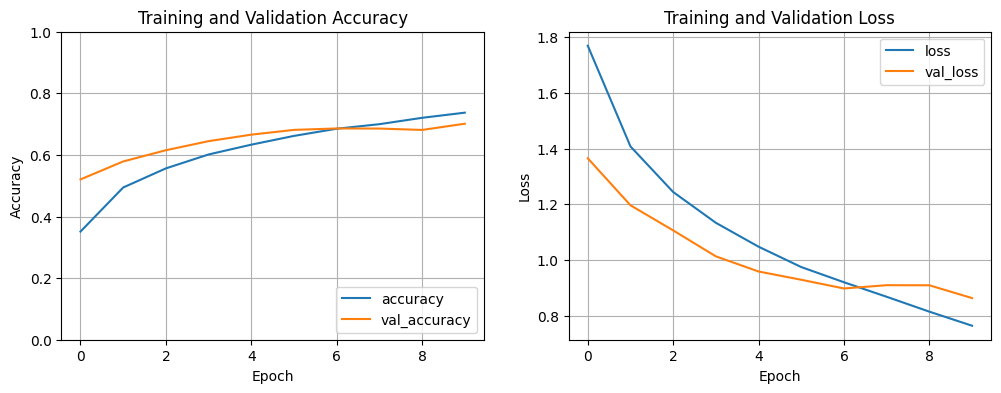

In [11]:
# Step 9: Plotting training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(trained_model.history['accuracy'], label='accuracy')
plt.plot(trained_model.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(trained_model.history['loss'], label='loss')
plt.plot(trained_model.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid()

plt.show()